# Genetic Algorithm for EV charging stations

In [1]:
import networkx as nx
import numpy as np
from itertools import product
import scipy.optimize as opt
import numpy.random as rd
import random
from typing import List, Tuple, Optional

from utils import output_image, distance

SEED = 342235

In [2]:
class GeneticAlgortihm:
    """
    Genetic algorithm to solve the problem of finding the optimal locations for new charging stations.
    """

    def __init__(
        self,
        width: int,
        height: int,
        num_poi: int,
        num_cs: int,
        num_new_cs: int,
        pop_size: int = 100,
        mutation_rate: float = 0.1,
        crossover_rate: float = 0.5,
        generations: int = 500,
        seed: Optional[int] = None,
    ) -> None:
        """
        Initialize the genetic algorithm.

        Args:
            width (int): Width of the grid.
            height (int): Height of the grid.
            num_poi (int): Number of points of interest.
            num_cs (int): Number of existing charging stations.
            num_new_cs (int): Number of new charging stations to place.
            pop_size (int, optional): Population size. Defaults to 100.
            mutation_rate (float, optional): Mutation rate. Defaults to 0.1.
            crossover_rate (float, optional): Crossover rate. Defaults to 0.5.
            generations (int, optional): Number of generations. Defaults to 500.
            seed (int, optional): Random seed. Defaults to None.
        """
        # Set random seed
        random.seed(seed)

        # Set up parameters
        self.width = width
        self.height = height
        self.num_new_cs = num_new_cs
        self.num_poi = num_poi
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.generations = generations
        self.population: List[List[Tuple[int, int]]] = []
        self.best_solution: Optional[List[Tuple[int, int]]] = None
        self.best_fitness = np.inf
        self.best_generation = 0

        # Set up scenario
        self.graph: Optional[nx.Graph] = None
        self.pois: Optional[List[Tuple[int, int]]] = None
        self.charging_stations: Optional[List[Tuple[int, int]]] = None
        self.potential_new_cs_nodes: Optional[List[Tuple[int, int]]] = None
        self.set_up_scenario(width, height, num_poi, num_cs)

    def set_up_scenario(
        self, width: int, height: int, num_poi: int, num_cs: int
    ) -> None:
        """
        Build scenario set up with specified parameters.

        Args:
            width (int): Width of grid.
            height (int): Height of grid.
            num_poi (int): Number of points of interest.
            num_cs (int): Number of existing charging stations.
        """
        # Create a grid graph
        self.graph = nx.grid_2d_graph(width, height)
        nodes = list(self.graph.nodes)

        # Identify a fixed set of points of interest and charging locations
        self.pois = random.sample(nodes, k=num_poi)
        self.charging_stations = random.sample(nodes, k=num_cs)

        # Identify potential new charging locations
        self.potential_new_cs_nodes = list(self.graph.nodes() - self.charging_stations)

    def init_population(self) -> None:
        """
        Initialize the population with random coordinates.
        """
        self.population = [
            random.choices(self.potential_new_cs_nodes, k=(self.num_new_cs))
            for _ in range(self.pop_size)
        ]

    def fitness(self, new_charging_nodes: List[Tuple[int, int]]) -> float:
        """
        Calculate the fitness of a solution.

        Args:
            new_charging_nodes (list): The solution to evaluate.

        Returns:
            float: The fitness of the solution.
        """
        min_dist = np.zeros(self.num_poi)
        for j, p in enumerate(self.pois):
            min_dist[j] = min(
                distance(p, c) for c in new_charging_nodes + self.charging_stations
            )
        return min_dist.sum()

    def tournament_selection(self, k: int = 2) -> List[Tuple[int, int]]:
        """
        Perform a tournament selection to select a parent.

        Args:
            k (int, optional): Number of individuals to select. Defaults to 2.

        Returns:
            List[Tuple[int, int]]: The selected parent.
        """
        selected = random.choices(self.population, k=k)
        return min(selected, key=self.fitness)

    def crossover(
        self, parent1: List[Tuple[int, int]], parent2: List[Tuple[int, int]]
    ) -> List[Tuple[int, int]]:
        """
        Perform a crossover operation between two parents.

        Args:
            parent1 (List[Tuple[int, int]]): The first parent.
            parent2 (List[Tuple[int, int]]): The second parent.

        Returns:
            List[Tuple[int, int]]: The crossover child.
        """
        child: List[Tuple[int, int]] = []
        for i in range(self.num_new_cs):
            if random.random() < 0.5:
                child.append(parent1[i])
            else:
                child.append(parent2[i])

        # Ensure uniqueness of genes (nodes) in the child
        unique_child = [tuple(node) for node in np.unique(child, axis=0).tolist()]

        # Fill in the remaining genes from either parent to maintain the correct length
        parent_combined = parent1 + parent2
        for node in parent_combined:
            if len(unique_child) < self.num_new_cs and node not in unique_child:
                unique_child.append(node)

        return unique_child

    def mutate(self, child: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        """
        Mutate a child by randomly changing the coordinates.

        Args:
            child (List[Tuple[int, int]]): The child to mutate.

        Returns:
            List[Tuple[int, int]]: The mutated child.
        """
        if random.random() < self.mutation_rate:
            mutated_child: List[Tuple[int, int]] = []
            for node in child:
                if random.random() < self.mutation_rate:
                    # Mutate x and y coordinates separately
                    new_x = node[0] + random.randint(-1, 1)
                    new_y = node[1] + random.randint(-1, 1)
                    # Ensure new coordinates are within grid bounds
                    new_x = max(0, min(new_x, self.width - 1))
                    new_y = max(0, min(new_y, self.height - 1))
                    mutated_child.append((new_x, new_y))
                else:
                    mutated_child.append(node)
            return mutated_child
        return child

    def run(self) -> None:
        """
        Run the genetic algorithm to solve the problem.
        """
        # Initialize the population
        self.init_population()
        for gen in range(self.generations):
            new_population: List[List[Tuple[int, int]]] = []
            for _ in range(self.pop_size):
                parent1 = self.tournament_selection()
                if random.random() < self.crossover_rate:
                    parent2 = self.tournament_selection()
                    child = self.crossover(parent1, parent2)
                else:
                    child = parent1
                child = self.mutate(child)
                new_population.append(child)
            self.population = new_population
            for candidate in self.population:
                fit = self.fitness(candidate)
                if fit < self.best_fitness:
                    self.best_fitness = fit
                    self.best_solution = candidate
                    self.best_generation = gen
        self.best_solution = [tuple(node) for node in self.best_solution]

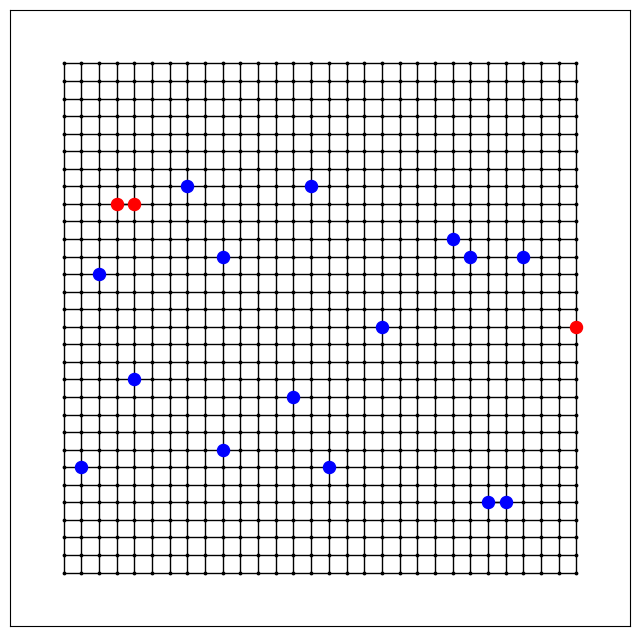

In [3]:
WIDTH = 30
HEIGHT = 30
POI = 15
CHARGERS = 3
NEW_CHARGERS = 4

gen = GeneticAlgortihm(WIDTH, HEIGHT, POI, CHARGERS, NEW_CHARGERS)
gen.init_population()
output_image(gen.graph, gen.pois, gen.charging_stations)

Best Solution:	 [(3, 8), (12, 8), (19, 18), (24, 4)] 
Generation:	 25 
Fitness:	 217.0


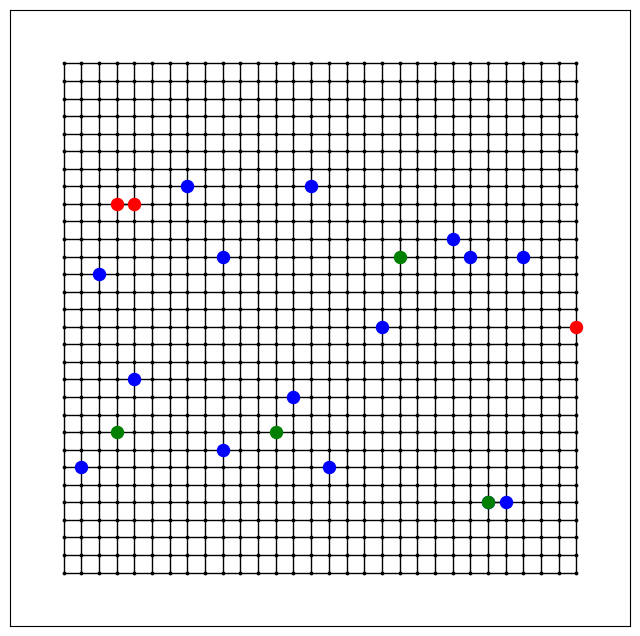

In [4]:
gen.run()
print("Best Solution:\t", gen.best_solution, "\nGeneration:\t", gen.best_generation,  "\nFitness:\t", gen.best_fitness)
output_image(gen.graph, gen.pois, gen.charging_stations, gen.best_solution)